Author: Marie Laure, `marielaure@bayesimpact.org`
# Application modes (IMT) Dataset retrieved from emploi-store-dev
The IMT dataset provides regional statistics about different jobs. Here we are interested in the "application modes" subset of this dataset. It gathers the means by which people find jobs.
Previously, we retrieved IMT data by scraping the IMT website. Concerning application modes, the present dataset not only proposes application modes ranks (as before) but also percentages per FAP codes.
As an exploratory step, we are interested in understanding what is the added value of the percentages compared to the ranks.

This dataset can be obtained with the following command:
docker-compose run --rm data-analysis-prepare make data/imt/application_modes.csv

## Loading and General View
First let's load the csv file:

In [1]:
import os
from os import path

import pandas as pd
import seaborn as _

DATA_FOLDER = os.getenv('DATA_FOLDER')

modes = pd.read_csv(path.join(DATA_FOLDER, 'imt/application_modes.csv'))
modes.head()


,APPLICATION_TYPE_CODE,APPLICATION_TYPE_NAME,APPLICATION_TYPE_ORDER,FAP_CODE,FAP_NAME,RECRUT_PERCENT
0,R3,Candidature spontanée,1,A0Z00,Agriculteurs indépendants,100.00
1,R2,Réseau personnel ou professionnel,1,A0Z40,Agriculteurs salariés,41.76
2,R3,Candidature spontanée,2,A0Z40,Agriculteurs salariés,29.26
3,R4,Autres canaux,3,A0Z40,Agriculteurs salariés,15.22
4,R1,Intermédiaires du placement,4,A0Z40,Agriculteurs salariés,13.76


Yeah! Here are the percentages!

## Dataset Sanity
We will check for data discrepancies.
Some variables (FAP, Application type) are expressed as codes and name. So we will check for their agreement.
We'll also investigate missing or weird data.

First, let's have a quick summary of the data.

In [2]:
modes.describe(include='all').head(2)

,APPLICATION_TYPE_CODE,APPLICATION_TYPE_NAME,APPLICATION_TYPE_ORDER,FAP_CODE,FAP_NAME,RECRUT_PERCENT
count,676,676,676.0,676,676,676.0
unique,4,4,NaN,195,195,NaN


Good news, Everything seems to be up here!
Let's see if there are any discrepancies between names and codes.
Starting with FAP (Job types).

In [3]:
modes.groupby('FAP_CODE').FAP_NAME.nunique().value_counts()

1    195
Name: FAP_NAME, dtype: int64

So far so good, Perfect concordance between FAP codes and FAP names.
It is worthy to note that these 195 FAP represents only a subset of the entire FAP (225) as they are described [here](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/statistiques-de-a-a-z/article/la-nomenclature-des-familles-professionnelles-fap-2009).

What about concordance between application type codes and names?

In [4]:
modes.groupby('APPLICATION_TYPE_CODE').APPLICATION_TYPE_NAME.nunique().value_counts()

1    4
Name: APPLICATION_TYPE_NAME, dtype: int64

We also have a 1 to 1 correspondance between application type codes and names.

Is there anything going weird between FAP code and the application type rank? Like two #1?

In [5]:
modes.groupby('FAP_CODE').APPLICATION_TYPE_CODE.value_counts().value_counts()

1    676
Name: APPLICATION_TYPE_CODE, dtype: int64

Nothing like that here.

Are there any weird values for ranks?


In [6]:
modes.APPLICATION_TYPE_ORDER.unique()

array([1, 2, 3, 4])

Nope, they are going from first to fourth and we've already seen that there are set for every FAP.

However there may be misassigned (e.g. an application type with fourth rank showing up alone).

In [7]:
def check_order(fap_modes):
    num_modes = len(fap_modes) 
        
    if num_modes == 1:
        if fap_modes.iloc[0].RECRUT_PERCENT != 100:
            raise Exception ('Single observations should have 100% percentage')
        if fap_modes.iloc[0].APPLICATION_TYPE_ORDER != 1:
            raise Exception ('Single observations should be ranked first')
        return
    for i in range(num_modes - 1):
        if int(fap_modes.APPLICATION_TYPE_ORDER.iloc[i]) != i + 1:
            raise Exception ('Rank order not consistent')
        if fap_modes.RECRUT_PERCENT.iloc[i] < \
            fap_modes.RECRUT_PERCENT.iloc[i + 1]:
            raise Exception ('Percentage order not consistent')    

modes.sort_values(\
    'APPLICATION_TYPE_ORDER').groupby('FAP_CODE').apply(check_order);

Everything is in order!

Let's take care of the new comer... The percentage. Basic stats?

In [8]:
modes.RECRUT_PERCENT.describe()

count    676.000000
mean      28.845769
std       18.307057
min        0.590000
25%       17.030000
50%       25.635000
75%       36.837500
max      100.000000
Name: RECRUT_PERCENT, dtype: float64

Here application modes not observed (0%) are not represented. So note that the mean has no real meaning here.

Let's end  by a manual check for dataset adequacy with Pôle Emploi website.
Application modes rank for "Tuyauteurs" on the 09/01/2017 at [IMT](http://candidat.pole-emploi.fr/marche-du-travail/statistiques?codeMetier=20475&codeZoneGeographique=69&typeZoneGeographique=DEPARTEMENT) is:
1. Candidature spontanée

Here we have:

In [9]:
modes[modes.FAP_CODE == 'D2Z41']

,APPLICATION_TYPE_CODE,APPLICATION_TYPE_NAME,APPLICATION_TYPE_ORDER,FAP_CODE,FAP_NAME,RECRUT_PERCENT
131,R3,Candidature spontanée,1,D2Z41,Tuyauteurs,100.0


Yay! We have a match!

Maybe we should check that the sum of the percentages are close to 100%?


In [10]:
def sum_percentages(fap_modes):
    num_modes = len(fap_modes) 
    sum = 0.0
    for i in range(num_modes):
        sum += fap_modes.RECRUT_PERCENT.iloc[i]
    if sum < 99.9 or sum > 100.1:
        print('{} {}'.format(fap_modes.FAP_CODE, sum))

modes.groupby('FAP_CODE').apply(sum_percentages)

""


For one FAP, the percentages sum to ~100%.

### Conclusion
I guess we're done for basic sanity checks.
Everything looks sane!


## Basic Overview
First let's see what are these application modes.

In [11]:
pd.options.display.max_colwidth = 100
modes.APPLICATION_TYPE_NAME.drop_duplicates().to_frame()


,APPLICATION_TYPE_NAME
0,Candidature spontanée
1,Réseau personnel ou professionnel
3,Autres canaux
4,Intermédiaires du placement


The different possibilities are not super precise... Thus, only 'Candidature spontanée', 'Réseau...' and 'Intermédiaires du placement can be directly useful.
For some FAP, only one, two or three application modes have been observed.

Let's have a look to how often this appears. 

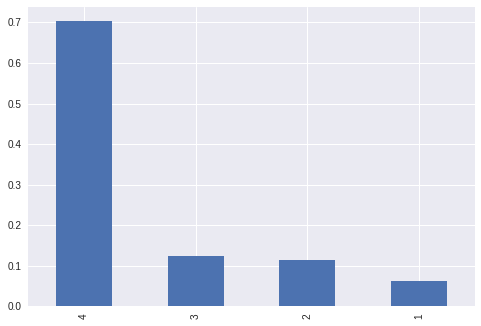

In [12]:
modes.groupby('FAP_CODE').size().value_counts(normalize=True).plot(kind='bar');

70% the job types have data for the 4 application modes. But we can still find some for which only 1 (<10%) or 2 modes (~10%) are observed.

So what is the application mode that is the most frequently ranked first?

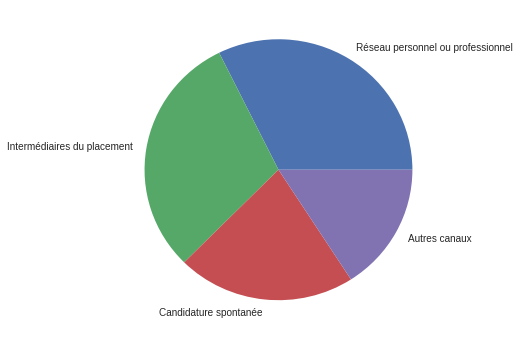

In [13]:
modes[modes.APPLICATION_TYPE_ORDER == 1]\
    .APPLICATION_TYPE_NAME.value_counts(normalize=True)\
    .plot.pie(figsize=(6, 6), label='');

Network seems to be slightly better than other modes. Nothing new for the Bayesian people...
However placement agencies gathers also 30% of the first rank modes.

Let's use percentages now by having a glimpse on the modes that represent more than half of the observations per job type.

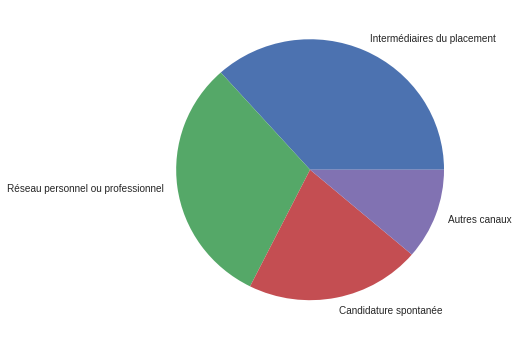

In [14]:
modes[modes.RECRUT_PERCENT >= 50].APPLICATION_TYPE_NAME\
    .value_counts(normalize=True)\
    .plot.pie(figsize=(6, 6), label='');

No doubt, when one channel is doing most of the job it's pretty often the network (36%). But except for the "others" category, other modes appears also to be successful. 

### Conclusion
Application mode definitions are not very granular. As we already knew, network ranks first, both when considering the ranks and taking into account application modes with more than 50% of the observations.
This make us think that there is space of personalisation. Next step will pursue on hos this dataset could be useful to us.


### Recommendations
#### 1. Basic
For example, we could investigate what are the job types for which application mode really makes the difference?
Let's start with the easiest. When only one mode shows up.


In [15]:
total_modes = modes.groupby('FAP_CODE').size()
modes['total_modes'] = modes.FAP_CODE.map(total_modes)
modes[modes.total_modes == 1][['APPLICATION_TYPE_NAME','FAP_NAME']]

,APPLICATION_TYPE_NAME,FAP_NAME
0,Candidature spontanée,Agriculteurs indépendants
131,Candidature spontanée,Tuyauteurs
197,Autres canaux,Ouvriers qualifiés du travail artisanal du textile et du cuir
224,Intermédiaires du placement,Carrossiers automobiles
225,Candidature spontanée,Mécaniciens et électroniciens de véhicules
279,Candidature spontanée,Contrôleurs des transports
294,Intermédiaires du placement,Cadres des transports
295,Candidature spontanée,Personnels navigants de l'aviation
358,Intermédiaires du placement,"Ingénieurs et cadres d'administration, maintenance en informatique"
389,Candidature spontanée,Magistrats


The case of independant farmers that mostly apply spontaneously for jobs opens the question of the scope of this application mode ('Candidature spontanée'). Maybe it also includes people that create or take over companies.
Here, for clear cut combinations of job type/application modes, use of professional or personal network is less represented.

What are the other jobs for which the application modes are really determinant? 
First we'll have a look to the gap between the modes ranked first and second. How clear cut it is?

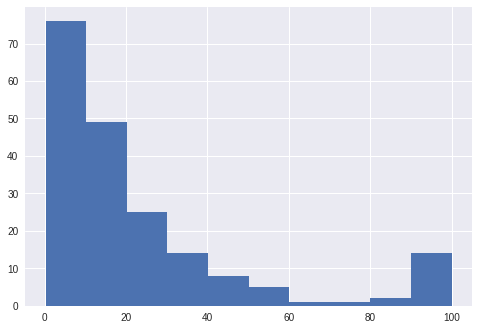

In [16]:
def compute_top2_diff(fap_modes):
    if len(fap_modes) == 1:
        return 100
    return fap_modes.iloc[0] - fap_modes.iloc[1]
top2_diff = modes.sort_values(\
    'APPLICATION_TYPE_ORDER').groupby('FAP_CODE').RECRUT_PERCENT.apply(compute_top2_diff)
top2_diff.hist();

Most of the time (124/195) there are less than a 20% difference between the first and the second application mode. But on right hand we can clearly see thats some application modes are highly recommended for certain jobs.

Let's have a look to application modes that gather more than 60% difference between first and second.

In [17]:
modes['top2_diff'] = modes.FAP_CODE.map(top2_diff)
modes[modes.top2_diff >= 60].APPLICATION_TYPE_NAME.value_counts()

Intermédiaires du placement          8
Candidature spontanée                7
Réseau personnel ou professionnel    7
Autres canaux                        3
Name: APPLICATION_TYPE_NAME, dtype: int64

Network is still there. But there are some job types for which we could recommend to have a look to placement agencies. Same for spontaneous application, maybe we could suggest hints to investigate the region specific ecosystem or job boards.

One of the main question was, what is the added value of percentages over ranks.
So let's have a look to the first rank. How diverse it is?

In [18]:
modes[modes.APPLICATION_TYPE_ORDER == 1].RECRUT_PERCENT.describe()

count    195.000000
mean      49.633949
std       18.674589
min       26.920000
25%       37.280000
50%       42.510000
75%       56.470000
max      100.000000
Name: RECRUT_PERCENT, dtype: float64

For half of the job types, the application mode ranked first represents less than half of the recruitment channels observed.

Is it more relevant to propose more than one, let's say two?

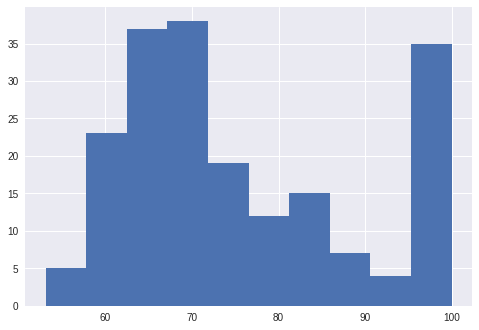

In [19]:
def compute_top2_sum(fap_modes):
    if len(fap_modes) == 1:
        return 100
    return fap_modes.iloc[0] + fap_modes.iloc[1]
top2_sum = modes.sort_values(\
    'APPLICATION_TYPE_ORDER').groupby('FAP_CODE').RECRUT_PERCENT.apply(compute_top2_sum)
top2_sum.hist();

It may be like pushing open doors here, but some users may benefits for more than one application mode suggestion (2). And for most job types, the first two modes gather more than 65% of the observations.

What are the jobs for which the first modes are almost equally relevant?

In [20]:
modes['top2_sum'] = modes.FAP_CODE.map(top2_sum)
modes[(modes.top2_sum > 70) & (modes.top2_diff < 15) & (modes.APPLICATION_TYPE_ORDER < 3)].\
    sort_values(['FAP_CODE', 'top2_sum'], ascending = False)

,APPLICATION_TYPE_CODE,APPLICATION_TYPE_NAME,APPLICATION_TYPE_ORDER,FAP_CODE,FAP_NAME,RECRUT_PERCENT,total_modes,top2_diff,top2_sum
664,R4,Autres canaux,1,W0Z91,Directeurs d'établissement scolaire et inspecteurs,48.14,3,2.67,93.61
665,R3,Candidature spontanée,2,W0Z91,Directeurs d'établissement scolaire et inspecteurs,45.47,3,2.67,93.61
656,R4,Autres canaux,1,W0Z80,Professeurs des écoles,39.55,4,2.38,76.72
657,R3,Candidature spontanée,2,W0Z80,Professeurs des écoles,37.17,4,2.38,76.72
652,R1,Intermédiaires du placement,1,V5Z84,Surveillants d'établissements scolaires,37.00,4,3.14,70.86
653,R3,Candidature spontanée,2,V5Z84,Surveillants d'établissements scolaires,33.86,4,3.14,70.86
648,R2,Réseau personnel ou professionnel,1,V5Z82,Sportifs et animateurs sportifs,40.63,4,10.75,70.51
649,R3,Candidature spontanée,2,V5Z82,Sportifs et animateurs sportifs,29.88,4,10.75,70.51
604,R3,Candidature spontanée,1,V2Z90,Médecins,49.83,3,10.30,89.36
605,R4,Autres canaux,2,V2Z90,Médecins,39.53,3,10.30,89.36


33 job types have less than a 15% difference between the first and the second application mode while both modes gather more than 70% of the observations. They include some public service job types (school principals or professors) that you can access by "concours" (permanent position) or spontaneous application/placement agencies (fixed-term contract). Users are already aware of these possibilities. But for other jobs like "cashiers", pushing both advice (spontaneous application and network) seems like a good strategy!

We know that for 70% of the job types the 4 application modes have been observed. For which job type the latest mode may be interesting? Let's see what is the distribution of the percentages of the least observed mode.

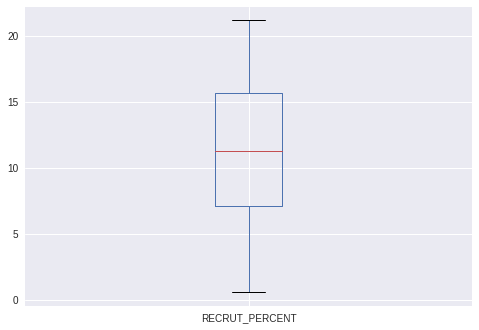

In [21]:
last_modes = modes[modes.APPLICATION_TYPE_ORDER == 4]
last_modes.RECRUT_PERCENT.plot(kind ='box');

The maximum percentage observed for the application mode ranked last, is 21%.

What are the job types for which the latest mode percentage is not that ridiculous (75th percentile)?

In [22]:
last_modes[last_modes.RECRUT_PERCENT > 16][['APPLICATION_TYPE_NAME', 'FAP_NAME', 'RECRUT_PERCENT']].\
sort_values('RECRUT_PERCENT', ascending = False)

,APPLICATION_TYPE_NAME,FAP_NAME,RECRUT_PERCENT
635,Candidature spontanée,Professionnels de l'orientation,21.16
631,Intermédiaires du placement,"Psychologues, psychothérapeutes",21.05
455,Intermédiaires du placement,Représentants auprès des particuliers,20.94
239,Candidature spontanée,Ingénieurs et cadres de fabrication et de la production,19.69
299,Candidature spontanée,"Ingénieurs et cadres de la logistique, du planning et de l'ordonnancement",19.69
262,Autres canaux,Conducteurs de véhicules légers,19.37
353,Autres canaux,"Techniciens de production, d'exploitation, d'installation, et de maintenance, support et service...",19.29
663,Intermédiaires du placement,Professeurs du secondaire,19.08
317,Autres canaux,Agents d'accueil et d'information,18.99
403,Réseau personnel ou professionnel,Employés de la banque et des assurances,18.97


Some of these results seem to be contradictory with our knowledge: e.g. the fact that network is ranked last for law professionals. Thus, we keep our main strategy of promoting the Network. However it seems relevant to drop spontaneous advice when users are interested in jobs in which this mode is almost never observed (here less than 16%).

#### 2. Network
Here at Bayes, we are conviced that Network is really important. Let's see if and how the application modes reported by newly recruited people enforce our statement.
First, how often is the network reported as the way newly recruited people?

In [23]:
modes[modes.APPLICATION_TYPE_CODE == 'R2'].APPLICATION_TYPE_ORDER.value_counts()

1    63
2    60
3    36
4    16
Name: APPLICATION_TYPE_ORDER, dtype: int64

There is only 20 job types for which Network has not been reported as an application mode. When it has been reported, it is usually ranked as the first or second application mode.

Among the jobs for which Network is ranked second for application mode

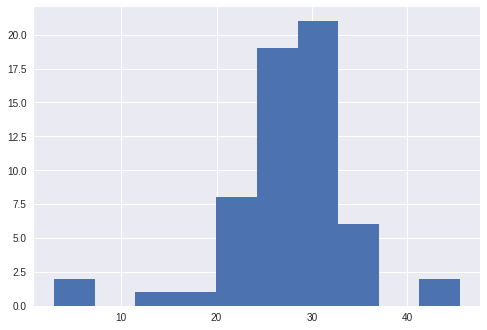

In [24]:
network_ranked_second = modes[(modes.APPLICATION_TYPE_ORDER == 2) & (modes.APPLICATION_TYPE_CODE == 'R2')]
network_ranked_second.RECRUT_PERCENT.hist();

There are only 2 cases where the Network is ranked second with more than 36% of the observations. Even if it won't concern that much job types, a threshold at 40% seems reasonable.

What about job types for which the Network mode does not reach this threshold?

In [25]:
network_ranked_second[network_ranked_second.RECRUT_PERCENT < 40].\
sort_values('RECRUT_PERCENT', ascending=False)[['FAP_NAME', 'RECRUT_PERCENT']]

,FAP_NAME,RECRUT_PERCENT
567,Cadres et techniciens de la documentation,36.97
30,Techniciens et agents d'encadrement d'exploitations agricoles,36.35
110,Ouvriers qualifiés de l'électricité et de l'électronique,34.24
76,Ouvriers qualifiés de la peinture et de la finition du bâtiment,33.34
174,Autres ouvriers qualifiés des industries agro-alimentaires (hors transformation des viandes),32.76
423,Caissiers,32.75
46,Ouvriers non qualifiés du gros oeuvre du bâtiment,32.70
42,"Ouvriers non qualifiés des travaux publics, du béton et de l'extraction",32.23
141,"Monteurs, ajusteurs et autres ouvriers qualifiés de la mécanique",31.96
518,"Coiffeurs, esthéticiens",31.81


It sounds sensible that these job types do not put network as their top mode of application. We expect the advice to be included in the two stars section. However, it appears that we could improve the phrasing for less qualified workers. 

The Job types that are above the 40% threshold are:

In [26]:
network_ranked_second[network_ranked_second.RECRUT_PERCENT >= 40].\
FAP_NAME.to_frame()

,FAP_NAME
305,Artisans et ouvriers qualifiés divers de type artisanal
565,Cadres de la communication


For these jobs, it appears relevant that the network advice is put in the user priorities.

Another way to personnalize the Network advice could be to put am emphasis on the observed percentage for the job types for which the advantage is striking.

In [27]:
network_ranked_first = modes[(modes.APPLICATION_TYPE_ORDER == 1) & (modes.APPLICATION_TYPE_CODE ==  'R2')]
network_ranked_first_ordered = network_ranked_first[['FAP_NAME', 'RECRUT_PERCENT', 'top2_diff', 'total_modes']].\
    sort_values('RECRUT_PERCENT', ascending=False)
network_ranked_first_ordered.head(10)

,FAP_NAME,RECRUT_PERCENT,top2_diff,total_modes
675,Professionnels de la politique,100.00,100.00,1
484,"Charcutiers, traiteurs",100.00,100.00,1
590,Écrivains,93.29,86.58,2
370,Agents des impôts et des douanes,82.86,69.21,3
379,Autres cadres B de la fonction publique,77.01,54.02,2
277,Agents d'exploitation des transports,73.86,47.72,2
24,"Viticulteurs, arboriculteurs salariés",71.21,53.56,4
533,Concierges,70.53,58.58,4
39,Cadres et maîtres d'équipage de la marine,70.21,40.42,2
570,Journalistes et cadres de l'édition,64.48,48.31,4


As an example, for the housekeepers (concierges), the network not only ranks first (70.53%) but also has a 58% difference with the application mode ranked second.

### Conclusion
This dataset allows to refine our understanding of application modes importance. Network is definitely a key point but, some job types have specific recruitment channels and for others, proposing more than one could be beneficial.
As an example, jobs for which first and second modes have been observed at similar rates and cover a large amount of the observations.
Concerning the Network advice, when Network is ranked second, we can use a 40% threshold to distinguish users for which Network can still be consider higher priority.
We can also use Spontaneous Application ranking or percentage to disable this advice for user for which it would not be relevant.


## General Conclusion
The dataset is super clean and ready to use.

Unfortunately, application modes definitions aren't very precise. The "Spontaneous Application" (candidature spontanée) mode might include also creating or taking over companies.
Even if, there are job types for which there is a super successful application mode, most of the time there is less than a 20% difference between the applicatiod modes ranked first and second. Furthermore, in fifty percent of the cases the application mode ranked first gathers only 42% of the successful modes.
Thus, percentages may help us to get a better coverage of what is working for a given job type.
Focusing on the network, it seems reasonable to set up a 40% threshold for the second ranked application modes to include a relevant runner-up. 

Finally, we should definetely investigate if switching from FAP to ROME codes influences consistency of the application modes ranking/percentage.

